**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: MR4010.10 - Navegación Auronoma**

Tecnológico de Monterrey

Prof David Antonio Torres

**Semana 7**
Actividad 4.2 - Detección de Señales de Tránsito

---

*   NOMBRE: Henry José Requena Molina
*   MATRÍCULA:

*   NOMBRE: Ariel Mora Monroy
*   MATRÍCULA:

*   NOMBRE: Abel Jhoan Díaz Escalera
*   MATRÍCULA:

*   NOMBRE: Jose Antonio Toledo Gonzalez
*   MATRÍCULA: A01796592

In [1]:
# Librerias a usar
%pip install numpy==1.26.4
%pip install imgaug
import cv2
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, SpatialDropout2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import glob
from sklearn.preprocessing import MinMaxScaler
import imgaug.augmenters as iaa
import random
%matplotlib inline

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("a1limacampos/navegacin-edge-ali-3")

print("Path to dataset files:", path)

100%|██████████| 48.0M/48.0M [00:03<00:00, 15.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/a1limacampos/navegacin-edge-ali-3/versions/1


In [6]:
import os

# List all files and folders in the dataset directory
dataset_path = "/root/.cache/kagglehub/datasets/a1limacampos/navegacin-edge-ali-3/versions/1"
for root, dirs, files in os.walk(dataset_path):
    for name in files:
        print(os.path.join(root, name))

/root/.cache/kagglehub/datasets/a1limacampos/navegacin-edge-ali-3/versions/1/Navegacion_Edge_Ali_3/data_log_edge.csv
/root/.cache/kagglehub/datasets/a1limacampos/navegacin-edge-ali-3/versions/1/Navegacion_Edge_Ali_3/data_edge/2025-06-22_04-43-31_734053.png
/root/.cache/kagglehub/datasets/a1limacampos/navegacin-edge-ali-3/versions/1/Navegacion_Edge_Ali_3/data_edge/2025-06-22_04-33-46_447763.png
/root/.cache/kagglehub/datasets/a1limacampos/navegacin-edge-ali-3/versions/1/Navegacion_Edge_Ali_3/data_edge/2025-06-22_04-42-00_940721.png
/root/.cache/kagglehub/datasets/a1limacampos/navegacin-edge-ali-3/versions/1/Navegacion_Edge_Ali_3/data_edge/2025-06-22_04-28-32_751767.png
/root/.cache/kagglehub/datasets/a1limacampos/navegacin-edge-ali-3/versions/1/Navegacion_Edge_Ali_3/data_edge/2025-06-22_04-27-47_156995.png
/root/.cache/kagglehub/datasets/a1limacampos/navegacin-edge-ali-3/versions/1/Navegacion_Edge_Ali_3/data_edge/2025-06-22_04-30-02_866878.png
/root/.cache/kagglehub/datasets/a1limacampo

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')


Recorte: x1=16, y1=0, ancho=288, alto=96


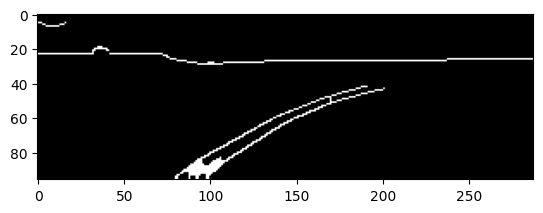

In [12]:
webots = glob.glob("/root/.cache/kagglehub/datasets/a1limacampos/navegacin-edge-ali-3/versions/1/Navegacion_Edge_Ali_3/data_edge/*.png")

# webots = glob.glob("C:/Users/anton/Desktop/Dataset/dataset_images1/*.png")
height, width = cv2.imread(webots[0]).shape[:2]
ratio = 3  # Ancho 3 veces el alto
# Definir ancho deseado (puede ser una fracción del ancho original)
desired_width = int(0.9 * width)  # 90% del ancho original, por ejemplo
desired_height = int(desired_width / ratio)

x1 = (width - desired_width) // 2
y1 = height - desired_height
print(f"Recorte: x1={x1}, y1={y1}, ancho={desired_width}, alto={desired_height}")

plt.imshow(cv2.imread(webots[0])[y1:, x1:x1 + desired_width])

In [9]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

def img_random_brightness(image):
  brightness = iaa.Multiply((0.7, 1.1))
  image = brightness.augment_image(image)
  return image

def img_random_flip(image, steering_angle):
  image = cv2.flip(image,1)
  steering_angle = -steering_angle
  return image, steering_angle

def random_augment(image, steering_angle):
  if np.random.rand() < 0.5:
      image = pan(image)
  if np.random.rand() < 0.5:
      image = zoom(image)
  if np.random.rand() < 0.5:
      image = img_random_brightness(image)
  if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image,steering_angle)
  return image, steering_angle

def img_preprocess(img):
  # img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  # img = img/255
  return img

In [16]:
webots = glob.glob("/root/.cache/kagglehub/datasets/a1limacampos/navegacin-edge-ali-3/versions/1/Navegacion_Edge_Ali_3/data_edge/*.png")
print("Screens - ", len(webots))

csv = "/root/.cache/kagglehub/datasets/a1limacampos/navegacin-edge-ali-3/versions/1/Navegacion_Edge_Ali_3/data_log_edge.csv"

dataset_webots = []
y = np.array([])

df = pd.read_csv(csv)
df['name'] = df['name'].str.split("\\").str[-1]
# webots = glob.glob("C:/Users/anton/Desktop/Dataset/dataset_images1/*.png")
# print("Screens - ", len(webots))

# csv = "C:/Users/anton/Desktop/Dataset/dataset_labels1.csv"

dataset_webots = []
y = np.array([])

df = pd.read_csv(csv)
df['name'] = df['name'].str.split("\\").str[-1]

for i in webots:
    img_color = mpimg.imread(i)

    # Ensure image is 3D (RGB). Convert grayscale to RGB by stacking.
    if img_color.ndim == 2:
        img_color = np.stack((img_color,) * 3, axis=-1)

    # Apply crop
    img_color = img_color[y1:, x1:x1 + desired_width, :]

    # Apply custom transformations
    img_pan  = pan(img_color)
    img_brightness = img_random_brightness(img_pan)
    img_prepro = img_preprocess(img_brightness)

    # Extract just the filename
    filename = i.split("/")[-1]

    # Match the filename in the dataframe
    if filename in df['name'].values:
        dataset_webots.append(img_prepro)
        steering_angle = round(df[df['name'] == filename]['angle'].values[0], 4)
        y = np.append(y, steering_angle)

print(len(dataset_webots))
print(y.shape)

Screens -  49044
49044
(49044,)


In [17]:
print(i)

/root/.cache/kagglehub/datasets/a1limacampos/navegacin-edge-ali-3/versions/1/Navegacion_Edge_Ali_3/data_edge/2025-06-22_04-35-38_666936.png


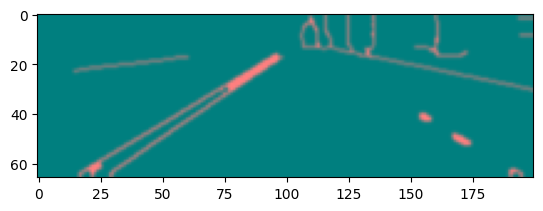

In [18]:
plt.imshow(dataset_webots[1000])

In [19]:
X = np.array(dataset_webots).astype('float32')
X = X.reshape(-1, X.shape[1], X.shape[2], 3)
print('X : ', X.shape)
print('Y : ', y.shape)

X :  (49044, 66, 200, 3)
Y :  (49044,)


(array([  629.,  6495., 14294.,  7277.,  6232.,  2091.,  3536.,  5584.,
         2412.,   494.]),
 array([-0.15 , -0.119, -0.088, -0.057, -0.026,  0.005,  0.036,  0.067,
         0.098,  0.129,  0.16 ]),
 <BarContainer object of 10 artists>)

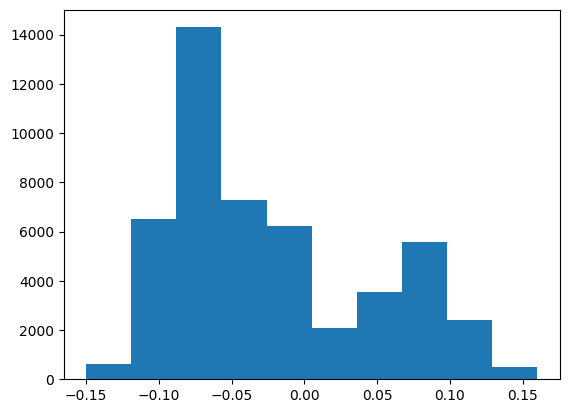

In [20]:
plt.hist(y)

In [21]:
zero_indices = np.where((y <= 0.007) & (y >= -0.007))[0]
print("Number of zero indices: ", len(zero_indices))

n_remove = int(len(zero_indices) * 0.75)
print("Number of zero indices to remove: ", n_remove)

remove_indices = np.random.choice(zero_indices, n_remove, replace=False)

mask = np.ones(len(y), dtype=bool)
mask[remove_indices] = False

x_filtrado = X[mask]
y_filtrado = y[mask]



Number of zero indices:  4313
Number of zero indices to remove:  3234


(array([  24.,  150.,    0.,   71.,  384.,    0., 1065.,    0., 2089.,
        3341.,    0., 6099., 4226.,    0., 3969.,    0., 3092., 2573.,
           0., 1612., 1370.,    0.,  549.,    0., 1079.,  997.,    0.,
         489.,    0.,  605.,  960.,    0.,  982., 1594.,    0., 1703.,
           0., 2248., 1633.,    0., 1194.,  471.,    0.,  747.,    0.,
         279.,   56.,    0.,  130.,   29.]),
 array([-0.15  , -0.1438, -0.1376, -0.1314, -0.1252, -0.119 , -0.1128,
        -0.1066, -0.1004, -0.0942, -0.088 , -0.0818, -0.0756, -0.0694,
        -0.0632, -0.057 , -0.0508, -0.0446, -0.0384, -0.0322, -0.026 ,
        -0.0198, -0.0136, -0.0074, -0.0012,  0.005 ,  0.0112,  0.0174,
         0.0236,  0.0298,  0.036 ,  0.0422,  0.0484,  0.0546,  0.0608,
         0.067 ,  0.0732,  0.0794,  0.0856,  0.0918,  0.098 ,  0.1042,
         0.1104,  0.1166,  0.1228,  0.129 ,  0.1352,  0.1414,  0.1476,
         0.1538,  0.16  ]),
 <BarContainer object of 50 artists>)

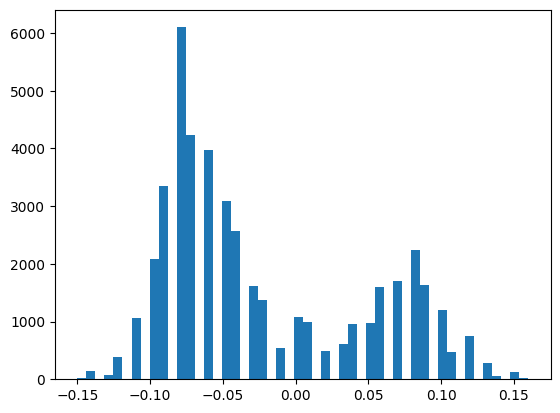

In [22]:
plt.hist(y_filtrado, bins=50)

In [23]:
scale = MinMaxScaler(feature_range=(-1, 1))
balanced_y = scale.fit_transform(y_filtrado.reshape(-1, 1)).flatten()
print("Balanced y shape: ", balanced_y.shape)


Balanced y shape:  (45810,)


(array([  24.,  150.,    0.,   71.,  384.,    0., 1065.,    0., 2089.,
        3341.,    0., 6099., 4226.,    0., 3969.,    0., 3092., 2573.,
           0., 1612., 1370.,    0.,  549.,    0., 1079.,  997.,    0.,
         489.,    0.,  605.,  960.,    0.,  982., 1594.,    0., 1703.,
           0., 2248., 1633.,    0., 1194.,  471.,    0.,  747.,    0.,
         279.,   56.,    0.,  130.,   29.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

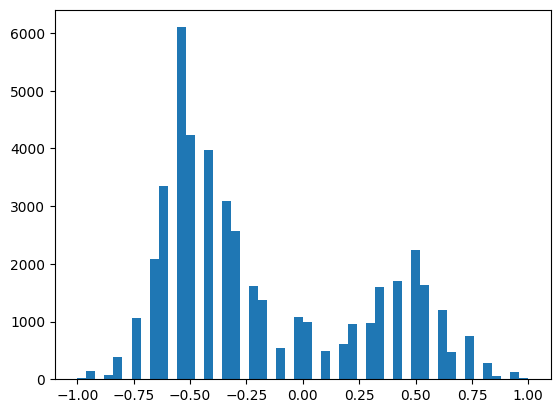

In [24]:
plt.hist(balanced_y, bins=50)

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x_filtrado, balanced_y, test_size=0.2, random_state=42)

print("Formato del array de imagenes de entrenamiento: ",x_train.shape)
print("Formato del array de los labels de entrenamiento: ", y_train.shape)
print("Formato del array de imagenes de prueba: ",x_test.shape)
print("Formato del aaray de los labels de prueba: ", y_test.shape)

Formato del array de imagenes de entrenamiento:  (36648, 66, 200, 3)
Formato del array de los labels de entrenamiento:  (36648,)
Formato del array de imagenes de prueba:  (9162, 66, 200, 3)
Formato del aaray de los labels de prueba:  (9162,)


In [26]:
# Declaración de nuestros dos mejores modelos para entrenar e hiperparametros para el modelo


def create_model_bn_5_dropout():

  model = Sequential()
  # Convolutional layers
  model.add(Conv2D(filters=20, kernel_size=(3, 3), activation='elu', input_shape=(66,200,3), padding="same"))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=20, kernel_size=(3, 3), activation='elu', input_shape=(66,200,3), padding="same"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(SpatialDropout2D(0.25))

  model.add(Conv2D(filters=40, kernel_size=(3, 3), activation='elu', padding="same"))
  model.add(Conv2D(filters=40, kernel_size=(3, 3), activation='elu', padding="same"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(SpatialDropout2D(0.2))

  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding="same"))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding="same"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(Dropout(0.15))

  # Fully Connected layers
  model.add(Flatten())
  model.add(Dense(units=384, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(units=192, activation='elu'))
  model.add(Dropout(0.2))
  model.add(Dense(units=1, activation='softmax'))

  return model

def create_model_bn_6_dropout():

  model = Sequential()
  # Convolutional layers
  model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='elu', input_shape=x_train.shape[1:], padding="same"))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='elu', input_shape=x_train.shape[1:], padding="same"))
  model.add(BatchNormalization())
  model.add(AveragePooling2D())
  model.add(SpatialDropout2D(0.2))

  model.add(Conv2D(filters=48, kernel_size=(3, 3), activation='elu', padding="same"))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=48, kernel_size=(3, 3), activation='elu', padding="same"))
  model.add(BatchNormalization())
  model.add(AveragePooling2D())
  model.add(SpatialDropout2D(0.2))

  model.add(Conv2D(filters=72, kernel_size=(3, 3), activation='elu', padding="same"))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=72, kernel_size=(3, 3), activation='elu', padding="same"))
  model.add(BatchNormalization())
  model.add(AveragePooling2D())
  model.add(Dropout(0.1))

  # Fully Connected layers
  model.add(Flatten())
  model.add(Dense(units=384, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(units=192, activation='elu'))
  model.add(Dropout(0.1))
  model.add(Dense(units=1))

  return model

def nvidia_model1():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Convolution2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(tf.keras.layers.Convolution2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(tf.keras.layers.Convolution2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='elu'))
  model.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='elu'))
  # model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(100, activation = 'elu'))
  model.add(tf.keras.layers.Dense(50, activation = 'elu'))
  model.add(tf.keras.layers.Dense(1, activation = 'linear')) # Changed to 1 unit and linear activation for regression
  # optimizer = Adam(lr=1e-3)
  # model.compile(loss='mse', optimizer=optimizer)
  return model

def nvidia_model():
    model = Sequential([
        Input(shape=(66, 200, 3)),

        Conv2D(24, (5, 5), strides=(2, 2), activation='elu'),
        BatchNormalization(),

        Conv2D(36, (5, 5), strides=(2, 2), activation='elu'),
        BatchNormalization(),

        Conv2D(48, (5, 5), strides=(2, 2), activation='elu'),
        BatchNormalization(),

        Conv2D(64, (3, 3), activation='elu'),
        BatchNormalization(),

        Conv2D(64, (3, 3), activation='elu'),
        BatchNormalization(),

        Flatten(),

        Dense(100, activation='elu'),
        Dropout(0.3),

        Dense(50, activation='elu'),
        Dropout(0.2),

        Dense(10, activation='elu'),

        Dense(1, activation='linear')  # Linear for regression
    ])

    return model

In [39]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import numpy as np

# --- Hyperparameters ---
batch_size = 128
epochs = 200
augment = True
patience = 10
learning_rate = 5e-4
seed = 42  # for reproducibility

# --- Callbacks ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0005,
    patience=patience,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# --- Model ---
model = nvidia_model()
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='mse',
    metrics=['mae']
)
model.summary()

# --- Data Handling ---
steps_per_epoch = len(x_train) // batch_size
validation_steps = len(x_test) // batch_size

if augment:
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        horizontal_flip=True
    )
    train_generator = datagen.flow(
        x_train, y_train,
        batch_size=batch_size,
        shuffle=True,
        seed=seed
    )

# --- Training ---
start = time.time()

print(f"Training started with augment = {augment}")
if augment:
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=(x_test, y_test),
        validation_steps=validation_steps,
        callbacks=[early_stopping, checkpoint],

        verbose=1
    )
else:
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
        callbacks=[early_stopping, checkpoint],
        verbose=1
    )

print("Training time: {:.2f} seconds".format(time.time() - start))



Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 31, 98, 24)     │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 14, 47, 36)     │           144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 5, 22, 48)      │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 3, 20, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 3, 20, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 1, 18, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 1, 18, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253,163 (988.92 KB)

 Trainable params: 252,691 (987.07 KB)

 Non-trainable params: 472 (1.84 KB)

Training started with augment = True


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - loss: 0.7757 - mae: 0.6279
Epoch 1: val_loss improved from inf to 0.11051, saving model to best_model.h5


286/286 ━━━━━━━━━━━━━━━━━━━━ 121s 388ms/step - loss: 0.7744 - mae: 0.6272 - val_loss: 0.1105 - val_mae: 0.2810
Epoch 2/200
  1/286 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1103 - mae: 0.2650

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.11051 to 0.10992, saving model to best_model.h5


286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1103 - mae: 0.2650 - val_loss: 0.1099 - val_mae: 0.2796
Epoch 3/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - loss: 0.1318 - mae: 0.2762
Epoch 3: val_loss improved from 0.10992 to 0.07404, saving model to best_model.h5


286/286 ━━━━━━━━━━━━━━━━━━━━ 105s 365ms/step - loss: 0.1317 - mae: 0.2761 - val_loss: 0.0740 - val_mae: 0.2106
Epoch 4/200
  1/286 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1164 - mae: 0.2670
Epoch 4: val_loss improved from 0.07404 to 0.07361, saving model to best_model.h5


286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1164 - mae: 0.2670 - val_loss: 0.0736 - val_mae: 0.2101
Epoch 5/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - loss: 0.1018 - mae: 0.2410
Epoch 5: val_loss improved from 0.07361 to 0.05481, saving model to best_model.h5


286/286 ━━━━━━━━━━━━━━━━━━━━ 104s 363ms/step - loss: 0.1018 - mae: 0.2410 - val_loss: 0.0548 - val_mae: 0.1748
Epoch 6/200
  1/286 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0873 - mae: 0.2367
Epoch 6: val_loss did not improve from 0.05481
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0873 - mae: 0.2367 - val_loss: 0.0553 - val_mae: 0.1754
Epoch 7/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - loss: 0.0847 - mae: 0.2179
Epoch 7: val_loss improved from 0.05481 to 0.05368, saving model to best_model.h5


286/286 ━━━━━━━━━━━━━━━━━━━━ 105s 366ms/step - loss: 0.0847 - mae: 0.2179 - val_loss: 0.0537 - val_mae: 0.1731
Epoch 8/200
  1/286 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0741 - mae: 0.2009
Epoch 8: val_loss improved from 0.05368 to 0.05332, saving model to best_model.h5


286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0741 - mae: 0.2009 - val_loss: 0.0533 - val_mae: 0.1725
Epoch 9/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - loss: 0.0732 - mae: 0.2037
Epoch 9: val_loss did not improve from 0.05332
286/286 ━━━━━━━━━━━━━━━━━━━━ 104s 363ms/step - loss: 0.0732 - mae: 0.2037 - val_loss: 0.2085 - val_mae: 0.3249
Epoch 10/200
  1/286 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0766 - mae: 0.2082
Epoch 10: val_loss did not improve from 0.05332
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0766 - mae: 0.2082 - val_loss: 0.1966 - val_mae: 0.3154
Epoch 11/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - loss: 0.0687 - mae: 0.1956
Epoch 11: val_loss did not improve from 0.05332
286/286 ━━━━━━━━━━━━━━━━━━━━ 104s 363ms/step - loss: 0.0687 - mae: 0.1956 - val_loss: 0.2043 - val_mae: 0.3190
Epoch 12/200
  1/286 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0633 - mae: 0.1875
Epoch 12: val_loss did not improve from 0.05332
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/

286/286 ━━━━━━━━━━━━━━━━━━━━ 104s 362ms/step - loss: 0.0585 - mae: 0.1817 - val_loss: 0.0428 - val_mae: 0.1561
Epoch 16/200
  1/286 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0583 - mae: 0.1917
Epoch 16: val_loss improved from 0.04283 to 0.04209, saving model to best_model.h5


286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0583 - mae: 0.1917 - val_loss: 0.0421 - val_mae: 0.1549
Epoch 17/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - loss: 0.0555 - mae: 0.1765
Epoch 17: val_loss improved from 0.04209 to 0.04076, saving model to best_model.h5


286/286 ━━━━━━━━━━━━━━━━━━━━ 104s 363ms/step - loss: 0.0555 - mae: 0.1765 - val_loss: 0.0408 - val_mae: 0.1541
Epoch 18/200
  1/286 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0582 - mae: 0.1811
Epoch 18: val_loss did not improve from 0.04076
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0582 - mae: 0.1811 - val_loss: 0.0421 - val_mae: 0.1570
Epoch 19/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - loss: 0.0541 - mae: 0.1752
Epoch 19: val_loss did not improve from 0.04076
286/286 ━━━━━━━━━━━━━━━━━━━━ 104s 362ms/step - loss: 0.0541 - mae: 0.1752 - val_loss: 0.1522 - val_mae: 0.2720
Epoch 20/200
  1/286 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0429 - mae: 0.1662
Epoch 20: val_loss did not improve from 0.04076
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0429 - mae: 0.1662 - val_loss: 0.1422 - val_mae: 0.2626
Epoch 21/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - loss: 0.0509 - mae: 0.1697
Epoch 21: val_loss did not improve from 0.04076
286/286 ━━━━━━━━━━━━━━━━━━━━ 104s 

287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0410 - mae: 0.1539
Test loss: [0.040760986506938934, 0.15411020815372467]


Text(0.5, 0, 'epoch')

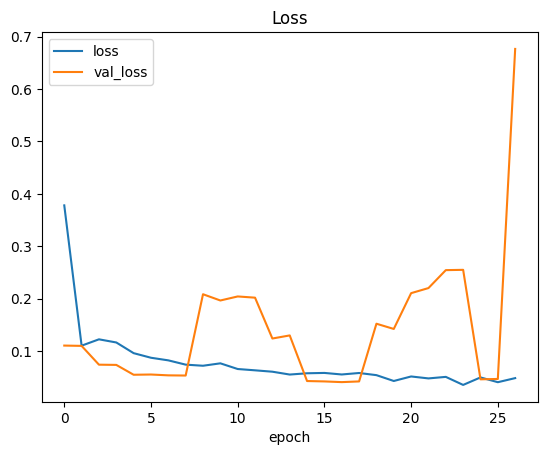

In [40]:
# Realizamos las preubas para calificar nuestro modelo acorde a las perdidas de nuestro dataset de entrenamiento y de test
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


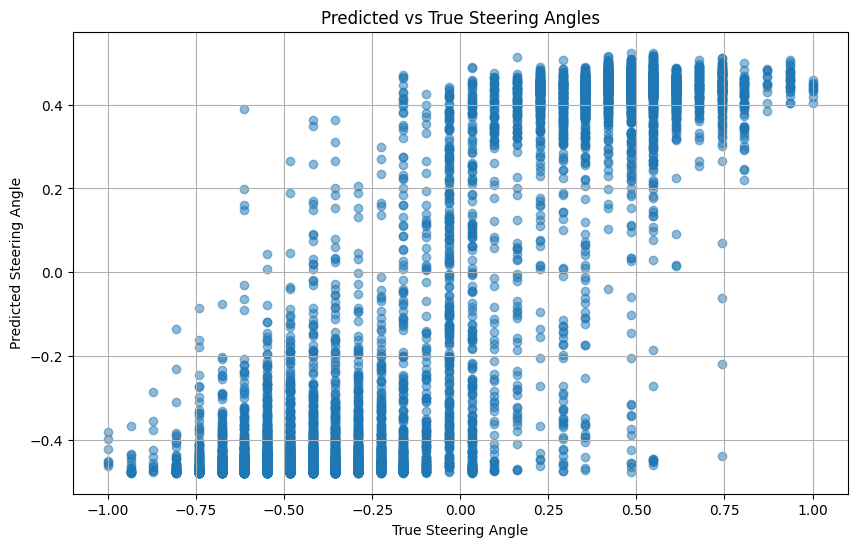

Porcentaje dentro de ±0.1: 22.66%
Porcentaje dentro de ±0.2: 39.20%
Porcentaje dentro de ±0.3: 49.26%
Porcentaje dentro de ±0.5: 59.35%


In [41]:
# Realizamos las preubas para calificar nuestro modelo acorde a las perdidas de nuestro dataset de entrenamiento y de test
y_predict = model.predict(x_test)
# y_predict = np.argmax(y_predict, axis=1) # Not needed for regression

# y_test_labels = np.argmax(y_test, axis=1) # Not needed for regression

# print(classification_report(y_test_labels, y_predict)) # Not applicable for regression
# cm = confusion_matrix(y_test_labels, y_predict) # Not applicable for regression

# plt.figure(figsize=(12, 10))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test_labels)) # Not applicable for regression
# disp.plot(cmap=plt.cm.Blues, ax=plt.gca()) # Not applicable for regression
# plt.title('Matriz de Confusión') # Not applicable for regression
# plt.xlabel('Predicciones') # Not applicable for regression
# plt.ylabel('Valores Reales') # Not applicable for regression
# plt.show() # Not applicable for regression

# Visualize predicted vs true steering angles with a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_predict, alpha=0.5)
plt.title('Predicted vs True Steering Angles')
plt.xlabel('True Steering Angle')
plt.ylabel('Predicted Steering Angle')
plt.grid(True)
plt.show()
for tol in [0.1, 0.2, 0.3, 0.5]:
    within_tol = np.abs(y_test - y_predict).flatten() < tol
    acc_like = np.mean(within_tol)
    print(f"Porcentaje dentro de ±{tol}: {acc_like*100:.2f}%")

In [42]:
model.save('model1.h5')

In [43]:
import os
print(os.getcwd())

/content


In [44]:
from google.colab import files
files.download('/content/model1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>